In [1]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.regularizers import l2
import keras_tuner
from keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import numpy as np
from scipy.stats import mode
import xgboost as xgb
import matplotlib.pyplot as plt
import plotly.express as px

## Méthode du benchmark

In [67]:
from sklearn import model_selection

path_to_data = r"C:\Users\meghn\Documents\Dauphine\Master\M2 Finance Quantitative\Semestre 2\Machine Learning\data\\"
train_home_team_statistics_df = pd.read_csv(path_to_data+'Train_Data/train_home_team_statistics_df.csv', index_col=0)
train_away_team_statistics_df = pd.read_csv(path_to_data+'Train_Data/train_home_team_statistics_df.csv', index_col=0)
train_scores = pd.read_csv(path_to_data+'y_train.csv', index_col=0)

train_home = train_home_team_statistics_df.iloc[:,2:]
train_away = train_away_team_statistics_df.iloc[:,2:]

train_home.columns = 'HOME_' + train_home.columns
train_away.columns = 'AWAY_' + train_away.columns

train_data =  pd.concat([train_home,train_away],join='inner',axis=1)
train_scores = train_scores.loc[train_data.index]

train_data = train_data.replace({np.inf:np.nan,-np.inf:np.nan})

train_new_y = train_scores['AWAY_WINS']
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_data, train_new_y, train_size=0.8, random_state=42)
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_train, y_train, train_size=0.8, random_state=42)


In [70]:
params_1 = {
    'booster': 'gbtree',
    'tree_method':'hist',
    'max_depth': 8, 
    'learning_rate': 0.025,
    'objective': 'multi:softprob',
    'num_class': 2,
    'eval_metric':'mlogloss'
    }


d_train = xgb.DMatrix(X_train.replace({0:np.nan}), y_train)
d_valid = xgb.DMatrix(X_valid.replace({0:np.nan}), y_valid)

num_round = 10000
evallist = [(d_train, 'train'), (d_valid, 'eval')]

bst = xgb.train(params_1, d_train, num_round, evallist, early_stopping_rounds=100)

X_test_xgb = xgb.DMatrix(X_test)

predictions = bst.predict(X_test_xgb, iteration_range=(0, bst.best_iteration))
predictions = pd.DataFrame(predictions)
target = train_scores.loc[X_test.index].copy()

predictions[2] = 0
predictions.columns = [0,2,1]
predictions = (predictions.reindex(columns=[0,1,2]).rank(1,ascending=False)==1).astype(int).values
print("Accuracy du benchmark:",np.round(accuracy_score(predictions,target),4))

[0]	train-mlogloss:0.68513	eval-mlogloss:0.68892
[1]	train-mlogloss:0.67719	eval-mlogloss:0.68483
[2]	train-mlogloss:0.66953	eval-mlogloss:0.68104


C:\Users\meghn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[3]	train-mlogloss:0.66238	eval-mlogloss:0.67722
[4]	train-mlogloss:0.65488	eval-mlogloss:0.67373
[5]	train-mlogloss:0.64817	eval-mlogloss:0.67003
[6]	train-mlogloss:0.64126	eval-mlogloss:0.66674
[7]	train-mlogloss:0.63437	eval-mlogloss:0.66369
[8]	train-mlogloss:0.62811	eval-mlogloss:0.66081
[9]	train-mlogloss:0.62169	eval-mlogloss:0.65804
[10]	train-mlogloss:0.61575	eval-mlogloss:0.65558
[11]	train-mlogloss:0.60954	eval-mlogloss:0.65275
[12]	train-mlogloss:0.60364	eval-mlogloss:0.65025
[13]	train-mlogloss:0.59801	eval-mlogloss:0.64800
[14]	train-mlogloss:0.59252	eval-mlogloss:0.64566
[15]	train-mlogloss:0.58750	eval-mlogloss:0.64356
[16]	train-mlogloss:0.58194	eval-mlogloss:0.64121
[17]	train-mlogloss:0.57636	eval-mlogloss:0.63910
[18]	train-mlogloss:0.57130	eval-mlogloss:0.63691
[19]	train-mlogloss:0.56660	eval-mlogloss:0.63482
[20]	train-mlogloss:0.56200	eval-mlogloss:0.63279
[21]	train-mlogloss:0.55749	eval-mlogloss:0.63080
[22]	train-mlogloss:0.55331	eval-mlogloss:0.62943
[23]	tr

## Solutions proposées

### Lecture des données

Dans notre projet, nous utilisons deux modules principaux pour le prétraitement des données : `DataPreparer` et `DataScaler`. Le module `DataPreparer` est responsable de la préparation initiale des données, incluant le nettoyage et l'ingénierie des features, tandis que le module `DataScaler` normalise les données pour les rendre adaptées aux algorithmes de machine learning. 


**Séparation des données en Entrainement et Test** <br>
Les données du _data challenge_ sont séparées entre un ensemble de données d'entraînement (train) et un ensemble de test. Cela est essentiel pour évaluer la performance réelle de notre modèle. <br>
Cependant,  nous avions initialement prévu d'utiliser les statistiques des joueurs des deux ensembles comme features pour notre modèle. En intégrant les données des joueurs dans nos features, nous maximisons l'utilisation de toutes les informations disponibles, ce qui devrait améliorer la performance du modèle. Cependant, la structure de nos données, avec des samples distincts pour l'ensemble d'entraînement et l'ensemble de test, rendait cela difficile quant au poids des données à gérer. Ainsi notre solution trouvée consiste à séparer notre ensemble d'entraînement initial en sous-ensembles d'entraînement et de test, nous pouvons mieux gérer les données des joueurs et intégrer ces informations dans nos features.


In [37]:
from PrepareData import DataPreparer
path_to_data = r"C:\Users\meghn\Documents\Dauphine\Master\M2 Finance Quantitative\Semestre 2\Machine Learning\data\\"
data_prep = DataPreparer(path = path_to_data, save_to_excel=False,train=True)
data_prep.prepare_data()
data_prep.save_data()

Saving the prepared data to data/prepared_data_train.parquet
Data prepared and saved!


In [2]:
feature_columns =['HOME_TEAM_SHOTS_TOTAL_season_sum', 'HOME_TEAM_SHOTS_INSIDEBOX_season_sum', 'HOME_TEAM_SHOTS_OFF_TARGET_season_sum', 'HOME_TEAM_SHOTS_ON_TARGET_season_sum', 'HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum', 'HOME_TEAM_PASSES_season_sum', 'HOME_TEAM_SUCCESSFUL_PASSES_season_sum', 'HOME_TEAM_SAVES_season_sum', 'HOME_TEAM_CORNERS_season_sum', 'HOME_TEAM_YELLOWCARDS_season_sum', 'HOME_TEAM_ATTACKS_season_sum', 'HOME_TEAM_DANGEROUS_ATTACKS_season_sum', 'HOME_TEAM_SHOTS_TOTAL_season_average', 'HOME_TEAM_SHOTS_INSIDEBOX_season_average', 'HOME_TEAM_SHOTS_OFF_TARGET_season_average', 'HOME_TEAM_SHOTS_ON_TARGET_season_average', 'HOME_TEAM_SHOTS_OUTSIDEBOX_season_average', 'HOME_TEAM_PASSES_season_average', 'HOME_TEAM_SUCCESSFUL_PASSES_PERCENTAGE_season_average', 'HOME_TEAM_SAVES_season_average', 'HOME_TEAM_BALL_POSSESSION_season_average', 'HOME_TEAM_YELLOWCARDS_season_average', 'HOME_TEAM_ATTACKS_season_average', 'HOME_TEAM_SHOTS_TOTAL_season_std', 'HOME_TEAM_SHOTS_INSIDEBOX_season_std', 'HOME_TEAM_SHOTS_OFF_TARGET_season_std', 'HOME_TEAM_SHOTS_ON_TARGET_season_std', 'HOME_TEAM_SHOTS_OUTSIDEBOX_season_std', 'HOME_TEAM_SUCCESSFUL_PASSES_season_std', 'HOME_TEAM_SUCCESSFUL_PASSES_PERCENTAGE_season_std', 'HOME_TEAM_SAVES_season_std', 'HOME_TEAM_CORNERS_season_std', 'HOME_TEAM_BALL_POSSESSION_season_std', 'HOME_TEAM_FOULS_season_std', 'HOME_TEAM_YELLOWCARDS_season_std', 'HOME_TEAM_OFFSIDES_season_std', 'HOME_TEAM_DANGEROUS_ATTACKS_season_std', 'HOME_TEAM_GOALS_season_std', 'HOME_TEAM_SHOTS_OFF_TARGET_5_last_match_sum', 'HOME_TEAM_SHOTS_OUTSIDEBOX_5_last_match_sum', 'HOME_TEAM_PASSES_5_last_match_sum', 'HOME_TEAM_SAVES_5_last_match_sum', 'HOME_TEAM_CORNERS_5_last_match_sum', 'HOME_TEAM_YELLOWCARDS_5_last_match_sum', 'HOME_TEAM_ATTACKS_5_last_match_sum', 'HOME_TEAM_SHOTS_OUTSIDEBOX_5_last_match_average', 'HOME_TEAM_PASSES_5_last_match_average', 'HOME_TEAM_SAVES_5_last_match_average', 'HOME_TEAM_YELLOWCARDS_5_last_match_average', 'HOME_TEAM_SHOTS_TOTAL_5_last_match_std', 'HOME_TEAM_SHOTS_INSIDEBOX_5_last_match_std', 'HOME_TEAM_SHOTS_OFF_TARGET_5_last_match_std', 'HOME_TEAM_SHOTS_ON_TARGET_5_last_match_std', 'HOME_TEAM_SHOTS_OUTSIDEBOX_5_last_match_std', 'HOME_TEAM_SUCCESSFUL_PASSES_PERCENTAGE_5_last_match_std', 'HOME_TEAM_SAVES_5_last_match_std', 'HOME_TEAM_CORNERS_5_last_match_std', 'HOME_TEAM_BALL_POSSESSION_5_last_match_std', 'HOME_TEAM_YELLOWCARDS_5_last_match_std', 'HOME_TEAM_ATTACKS_5_last_match_std', 'AWAY_TEAM_SHOTS_TOTAL_season_sum', 'AWAY_TEAM_SHOTS_INSIDEBOX_season_sum', 'AWAY_TEAM_SHOTS_OFF_TARGET_season_sum', 'AWAY_TEAM_SHOTS_ON_TARGET_season_sum', 'AWAY_TEAM_SHOTS_OUTSIDEBOX_season_sum', 'AWAY_TEAM_PASSES_season_sum', 'AWAY_TEAM_SUCCESSFUL_PASSES_season_sum', 'AWAY_TEAM_CORNERS_season_sum', 'AWAY_TEAM_YELLOWCARDS_season_sum', 'AWAY_TEAM_ATTACKS_season_sum', 'AWAY_TEAM_DANGEROUS_ATTACKS_season_sum', 'AWAY_TEAM_SHOTS_TOTAL_season_average', 'AWAY_TEAM_SHOTS_INSIDEBOX_season_average', 'AWAY_TEAM_SHOTS_OFF_TARGET_season_average', 'AWAY_TEAM_SHOTS_OUTSIDEBOX_season_average', 'AWAY_TEAM_SUCCESSFUL_PASSES_PERCENTAGE_season_average', 'AWAY_TEAM_CORNERS_season_average', 'AWAY_TEAM_YELLOWCARDS_season_average', 'AWAY_TEAM_SHOTS_TOTAL_season_std', 'AWAY_TEAM_SHOTS_INSIDEBOX_season_std', 'AWAY_TEAM_SHOTS_OFF_TARGET_season_std', 'AWAY_TEAM_SHOTS_ON_TARGET_season_std', 'AWAY_TEAM_SUCCESSFUL_PASSES_season_std', 'AWAY_TEAM_SUCCESSFUL_PASSES_PERCENTAGE_season_std', 'AWAY_TEAM_CORNERS_season_std', 'AWAY_TEAM_FOULS_season_std', 'AWAY_TEAM_YELLOWCARDS_season_std', 'AWAY_TEAM_OFFSIDES_season_std', 'AWAY_TEAM_GOALS_season_std', 'AWAY_TEAM_SHOTS_TOTAL_5_last_match_sum', 'AWAY_TEAM_SHOTS_OFF_TARGET_5_last_match_sum', 'AWAY_TEAM_SHOTS_ON_TARGET_5_last_match_sum', 'AWAY_TEAM_SHOTS_OUTSIDEBOX_5_last_match_sum', 'AWAY_TEAM_CORNERS_5_last_match_sum', 'AWAY_TEAM_ATTACKS_5_last_match_sum', 'AWAY_TEAM_DANGEROUS_ATTACKS_5_last_match_sum', 'AWAY_TEAM_SHOTS_TOTAL_5_last_match_average', 'AWAY_TEAM_SHOTS_OUTSIDEBOX_5_last_match_average', 'AWAY_TEAM_SUCCESSFUL_PASSES_PERCENTAGE_5_last_match_average', 'AWAY_TEAM_SAVES_5_last_match_average', 'AWAY_TEAM_DANGEROUS_ATTACKS_5_last_match_average', 'AWAY_TEAM_SHOTS_INSIDEBOX_5_last_match_std', 'AWAY_TEAM_SHOTS_OFF_TARGET_5_last_match_std', 'AWAY_TEAM_SHOTS_OUTSIDEBOX_5_last_match_std', 'AWAY_TEAM_YELLOWCARDS_5_last_match_std', 'AWAY_TEAM_PENALTIES_5_last_match_std', 'HOME_PLAYERS_PLAYER_DRIBBLED_PAST_season_sum_SUM', 'HOME_PLAYERS_PLAYER_HIT_WOODWORK_season_sum_SUM', 'HOME_PLAYERS_PLAYER_PENALTIES_SAVED_season_sum_SUM', 'HOME_PLAYERS_PLAYER_REDCARDS_season_sum_SUM', 'HOME_PLAYERS_PLAYER_SHOTS_BLOCKED_season_sum_SUM', 'HOME_PLAYERS_PLAYER_YELLOWCARDS_season_sum_SUM', 'HOME_PLAYERS_PLAYER_ACCURATE_CROSSES_season_average_SUM', 'HOME_PLAYERS_PLAYER_ASSISTS_season_average_SUM', 'HOME_PLAYERS_PLAYER_DUELS_LOST_season_average_SUM', 'HOME_PLAYERS_PLAYER_PASSES_season_average_SUM', 'HOME_PLAYERS_PLAYER_SHOTS_TOTAL_season_average_SUM', 'HOME_PLAYERS_PLAYER_ACCURATE_PASSES_season_std_SUM', 'HOME_PLAYERS_PLAYER_ACCURATE_PASSES_PERCENTAGE_season_std_SUM', 'HOME_PLAYERS_PLAYER_HIT_WOODWORK_season_std_SUM', 'HOME_PLAYERS_PLAYER_KEY_PASSES_season_std_SUM', 'AWAY_PLAYERS_PLAYER_BIG_CHANCES_MISSED_season_average_SUM', 'AWAY_PLAYERS_PLAYER_SHOTS_ON_TARGET_season_average_SUM']

In [3]:
from GetData import DataScaler
data_scaler = DataScaler(train=True)
data, _, target_column = data_scaler.get_data()

Removed 13.08% of columns because they have more than 20% of values missing
Removed 16.34% of columns because they have only one value
Removed 44.42% of rows because they have missing values


Dans la classe `DataPreparer`, nous avons réalisé un mapping des scores : 0 si victoire à domicile, 1 si match nul et 2 si défaite à domicile. Cela nous permet de rassembler les résultats de 3 colonnes en une.

In [4]:
for cat in data["results"].unique():
    print(cat, len(data[data["results"] == cat]))

2 2100
1 1761
0 2977


### Séparation de nos ensembles d'entraînement

La zone de code ci-dessous est utile lorsque qu'on souhaite séparer le train set en un ensemble train et test. Cependant, si nous en avions la capacité informatique, nous aurions utilisé les données test fournies.

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[feature_columns])
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, 
	data[target_column], 
	test_size=0.2, 
	random_state=42,
	stratify=data[target_column],
	shuffle=True
	)

### 1. Modèle non supervisé - différenciation des clusters

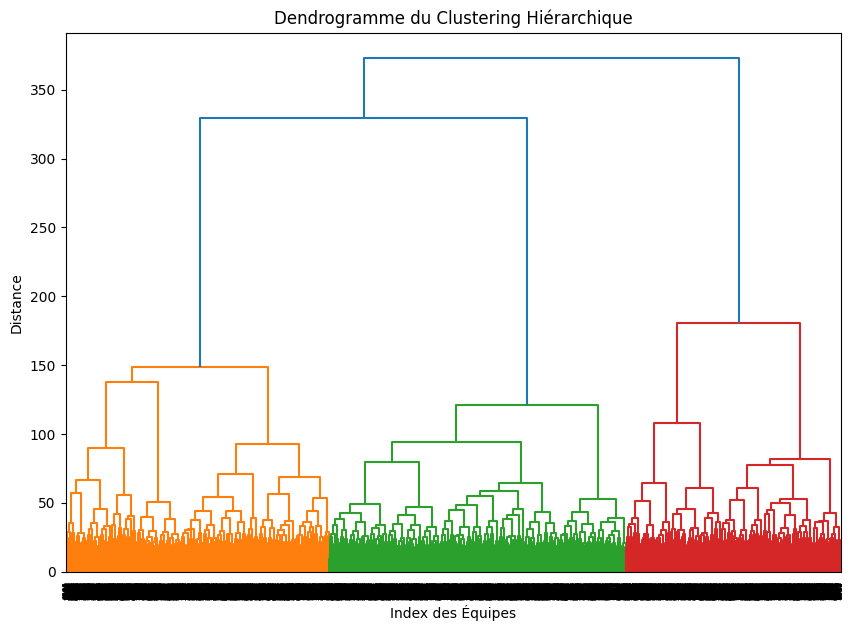

In [6]:
linked = linkage(X_scaled, method='ward')  
plt.figure(figsize=(10, 7))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Dendrogramme du Clustering Hiérarchique')
plt.xlabel('Index des Équipes')
plt.ylabel('Distance')
plt.show()

Nous pouvons que nous avons 3 clusters (trois couleurs). Déterminons désormais le seuil de coupe optimal pour ces 3 clusters.

In [7]:
best_threshold = 0
best_silhouette = -1
for threshold in range(100, 351, 50):
    labels = fcluster(linked, t=threshold, criterion='distance')
    num_clusters = len(set(labels))
    if num_clusters > 1:
        silhouette_avg = silhouette_score(X_scaled, labels)
        print(f"Pour une hauteur de coupe de {threshold}, l'indice de silhouette est : {silhouette_avg:.10f}")
    else:
        print(f"Pour une hauteur de coupe de {threshold}, nombre de clusters générés est {num_clusters}. Indice de silhouette non calculé.")
    if silhouette_avg > best_silhouette:
        best_silhouette = silhouette_avg
        best_threshold = threshold

print(f"Meilleur seuil de coupe: {best_threshold} avec un indice de silhouette de {best_silhouette:.10f}")

Pour une hauteur de coupe de 100, l'indice de silhouette est : 0.0102746825
Pour une hauteur de coupe de 150, l'indice de silhouette est : 0.0497239324
Pour une hauteur de coupe de 200, l'indice de silhouette est : 0.0707560362
Pour une hauteur de coupe de 250, l'indice de silhouette est : 0.0707560362
Pour une hauteur de coupe de 300, l'indice de silhouette est : 0.0707560362
Pour une hauteur de coupe de 350, l'indice de silhouette est : 0.0922291112
Meilleur seuil de coupe: 350 avec un indice de silhouette de 0.0922291112


C:\Users\meghn\AppData\Local\Temp\ipykernel_11320\3375930456.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['cluster'] = kmeans.labels_


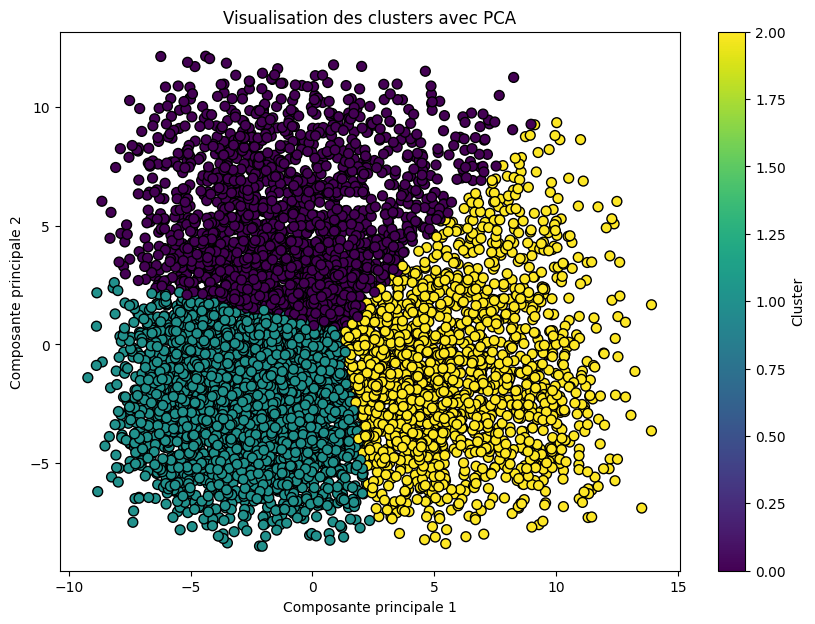

In [8]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)
data['cluster'] = kmeans.labels_

cluster_labels = fcluster(linked, t=350 , criterion='distance')
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data['cluster'], cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('Visualisation des clusters avec PCA')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.colorbar(label='Cluster')
plt.show()

La partition des clusters est homogène et bien séparée: c'est un bon clustering.

Nous avons ici deux choix pour notre modèle non-supervisé : soit nous réalisons une optimisation de l'accuracy, soit du score de silhouette. A noter que les autres métriques sont mesurées en fonction de l'accuracy donc cela permet de comparer nos résultats à travers les modèles. 

In [9]:
def map_clusters_to_labels(cluster_labels, true_labels):
    labels = np.zeros_like(cluster_labels)
    for cluster in np.unique(cluster_labels):
        mask = (cluster_labels == cluster)
        labels[mask] = mode(true_labels[mask])[0]
    return labels

In [10]:
clusters = data['cluster']
labels = data['results']

mapped_labels = map_clusters_to_labels(clusters, labels)
accuracy = accuracy_score(data['results'], mapped_labels)
print(f"Clustering Accuracy: {accuracy:.4f}")

Clustering Accuracy: 0.4873


Nous avons une accuracy supérieure à celle du benchmark pour ces 3 clusters ! 

Essayons désormais d'optimiser ce modèle avec un Grid Search de validation croisée. <br> Ici, nous essayons d'optimiser le score de silhouette en premier lieu.

In [11]:
#################################### PARAMETRES POUR LA GRID SEARCH CV ####################################
pipeline_Kmeans = Pipeline([
    ('kmeans', KMeans(random_state=42))
])

param_grid_Kmeans = {
    'kmeans__n_clusters': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'kmeans__init': ['k-means++', 'random'],
    'kmeans__n_init': [10, 20, 30]
}

**Score de silhouette**

In [12]:
def silhouette_scorer(estimator, X):
    cluster_labels = estimator.fit_predict(X)
    return silhouette_score(X, cluster_labels)

grid_search_silhouette = GridSearchCV(pipeline_Kmeans, param_grid_Kmeans, cv=5, scoring=silhouette_scorer)
grid_search_silhouette.fit(X_train)

print(f"Meilleurs paramètres: {grid_search_silhouette.best_params_}")
print(f"Meilleurs Score de Silhouette : {grid_search_silhouette.best_score_:.4f}")

best_kmeans = grid_search_silhouette.best_estimator_.named_steps['kmeans']
data['cluster'] = best_kmeans.fit_predict(X_scaled)

Meilleurs paramètres: {'kmeans__init': 'k-means++', 'kmeans__n_clusters': 2, 'kmeans__n_init': 10}
Meilleurs Score de Silhouette : 0.1192


_Accuracy_

In [13]:
test_clusters = best_kmeans.fit_predict(X_test)
mapped_labels = map_clusters_to_labels(test_clusters, y_test)
accuracy = accuracy_score(y_test, mapped_labels)
print(f"Clustering Accuracy sur l'ensemble de test: {accuracy:.4f}")

Clustering Accuracy sur l'ensemble de test: 0.4357


Nous pouvons constater qu'avec un score de silhouette optimisé, nous avons une accuracy plus faible que la méthode du benchmark. Réalisons désormais la visualisation des deux clusters (seuil optimal pour celui-ci). Nous devons d'abord réduire les dimensions avec une ACP puisque nous avons beaucoup de colonnes (donc dimensions).

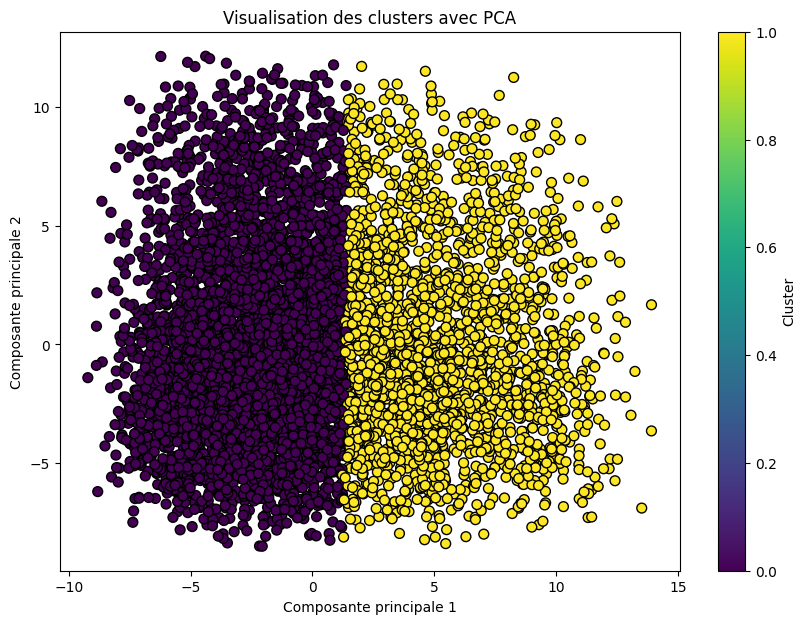

In [14]:
# Réduction de dimensionnalité avec PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data[feature_columns])

# Visualiser les clusters en 2D
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data['cluster'], cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('Visualisation des clusters avec PCA')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.colorbar(label='Cluster')
plt.show()

La partition des clusters est homogène et bien séparée : c'est un bon clustering. Cependant, 2 clusters paraît faible par rapport aux résultats précedents.

**Score d'accuracy**

In [15]:
def accuracy_scorer(estimator, X, y):
    cluster_labels = estimator.fit_predict(X)
    labels = np.zeros_like(cluster_labels)
    for cluster in np.unique(cluster_labels):
        mask = (cluster_labels == cluster)
        labels[mask] = mode(y[mask])[0]
    return accuracy_score(y, labels)

grid_search_acc = GridSearchCV(pipeline_Kmeans, param_grid_Kmeans, cv=5, scoring=lambda estimator, X_train, y_train: accuracy_scorer(estimator, X_train, y_train))
grid_search_acc.fit(X_train, y_train)

print(f"Meilleurs paramètres: {grid_search_acc.best_params_}")
print(f"Meilleur Score d'Accuracy : {grid_search_acc.best_score_:.4f}")

# Clustering avec les meilleurs paramètres
best_kmeans = grid_search_acc.best_estimator_.named_steps['kmeans']
train_clusters = best_kmeans.fit_predict(X_train)
mapped_labels_tr = map_clusters_to_labels(train_clusters, y_train)
accuracy = accuracy_score(y_train, mapped_labels_tr)
print(f"Clustering Accuracy sur l'ensemble train: {accuracy:.4f}")

# On calcule l'accuracy finale
test_clusters = best_kmeans.fit_predict(X_test)
mapped_labels_t = map_clusters_to_labels(test_clusters, y_test)
accuracy = accuracy_score(y_test, mapped_labels_t)
print(f"Clustering Accuracy sur l'ensemble test: {accuracy:.4f}")


Meilleurs paramètres: {'kmeans__init': 'k-means++', 'kmeans__n_clusters': 9, 'kmeans__n_init': 10}
Meilleur Score d'Accuracy : 0.4985
Clustering Accuracy sur l'ensemble train: 0.4967
Clustering Accuracy sur l'ensemble test: 0.4832


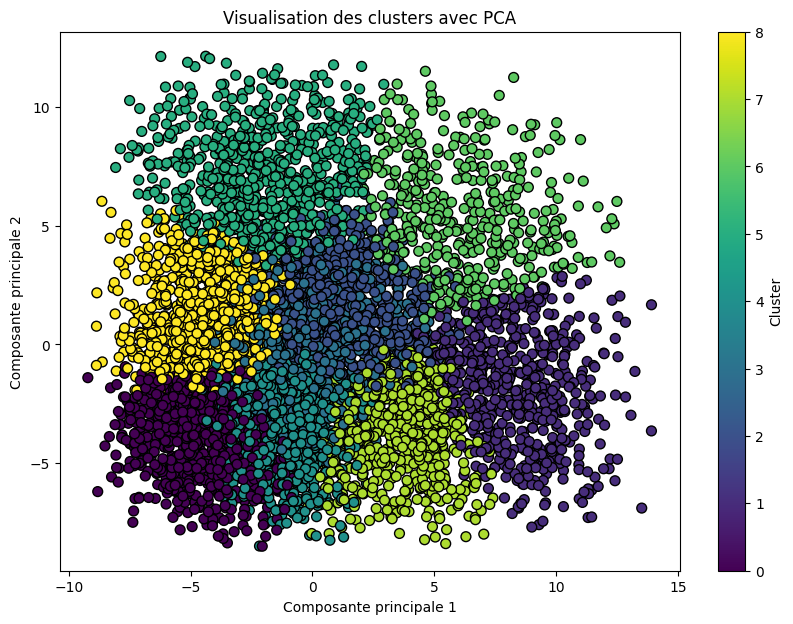

In [16]:
data['cluster'] = best_kmeans.fit_predict(X_scaled)
# Réduction de dimensionnalité avec PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualiser les clusters en 2D
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data['cluster'], cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('Visualisation des clusters avec PCA')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.colorbar(label='Cluster')
plt.show()


Nous pouvons constater que certains clusters ne sont pas bien séparés en 2D. Ainsi, ils peuvent l'être en 3D. Pour cela nous changeons l'ACP afin qu'elle ait 3 composantes.

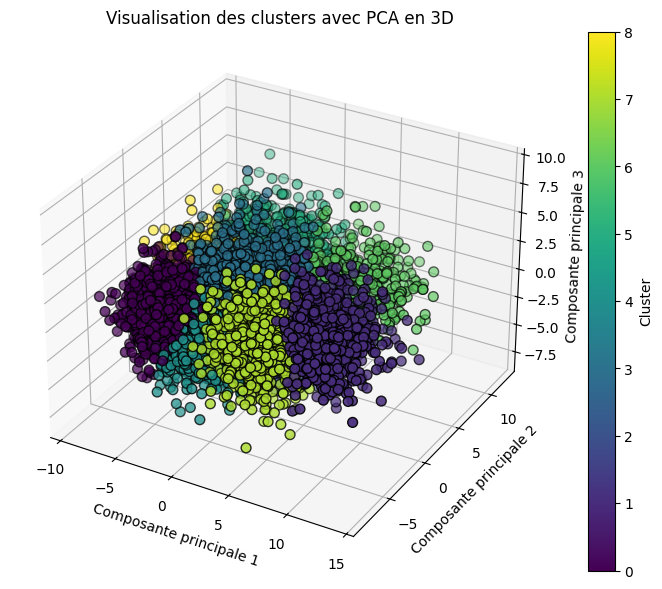

In [17]:
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
X_pca_3d = pca.fit_transform(X_scaled)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=data['cluster'], cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('Visualisation des clusters avec PCA en 3D')
ax.set_xlabel('Composante principale 1')
ax.set_ylabel('Composante principale 2')
ax.set_zlabel('Composante principale 3')
plt.colorbar(sc, label='Cluster')
plt.show()


Nous voyons qu'en 3D les clusters ont bien l'air d'être bien séparés et divisés.
Ce modèle a donc une performance supérieure à celle du benchmark (accuracy). En effet, avec un meilleur score d'accuracy sur l'ensemble de test (50%), cela est supérieur à la méthode du bench (0.46).

### 2. Modèle de régression logistique

Testons un modèle simple de régression logistique.

In [22]:
model_LR = LogisticRegression(solver='liblinear')  
model_LR.fit(X_train, y_train)
predictions = model_LR.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))
print("Classification Report:\n", classification_report(y_test, predictions))


Accuracy: 0.4934210526315789
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.75      0.62       596
           1       0.30      0.07      0.12       352
           2       0.46      0.48      0.47       420

    accuracy                           0.49      1368
   macro avg       0.43      0.43      0.40      1368
weighted avg       0.45      0.49      0.45      1368



In [20]:
param_grid_LR = {
    'C': [0.01, 0.1, 1, 10, 100],  
    'penalty': ['l1', 'l2']        
}

In [19]:
def model_fit_predict_CV(model, grid_search:dict, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print("Accuracy :", accuracy_score(y_test, predictions))
    grid_search = GridSearchCV(estimator=model, param_grid=grid_search, cv=5, verbose=2, n_jobs=-1, scoring='accuracy')    
    grid_search.fit(X_train, y_train)
    print("Meilleurs paramètres trouvés :", grid_search.best_params_)
    print("Meilleur score de validation croisée :", grid_search.best_score_)
    best_model = grid_search.best_estimator_
    test_predictions = best_model.predict(X_test)
    print("Accuracy sur l'ensemble de test :", accuracy_score(y_test, test_predictions))
    print("Rapport de classification :\n", classification_report(y_test, test_predictions))

In [21]:
model_fit_predict_CV(model_LR, param_grid_LR, X_train, y_train, X_test, y_test)

Accuracy : 0.4934210526315789
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Meilleurs paramètres trouvés : {'C': 0.01, 'penalty': 'l1'}
Meilleur score de validation croisée : 0.5016453382084095
Accuracy sur l'ensemble de test : 0.489766081871345
Rapport de classification :
               precision    recall  f1-score   support

           0       0.50      0.82      0.62       596
           1       0.00      0.00      0.00       352
           2       0.46      0.43      0.45       420

    accuracy                           0.49      1368
   macro avg       0.32      0.42      0.36      1368
weighted avg       0.36      0.49      0.41      1368



C:\Users\meghn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\meghn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\meghn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

Ce modèle simple a une accuracy très prommetteuse malgré sa méthode simple ! De plus, les résultats sont généralisables à l'ensemble de test avec une accuracy toujours plus élevée que celle du benchmark.

### 3. Modèle supervisé : Random Forest Classfier

In [23]:
#################################### PARAMETRES POUR LA GRID SEARCH CV ####################################
param_grid_RF = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [10, 20, 30],        
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4]     
}

In [24]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
predictions_rf = rf_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions_rf))


Accuracy: 0.4766081871345029


A premier abord, nous avons une accuracy pour ce modèle plus faible que pour le clustering où l'on optimisait l'accuracy.

In [25]:
model_fit_predict_CV(rf_model, param_grid_RF, X_train, y_train, X_test, y_test)

Accuracy : 0.4766081871345029
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Meilleurs paramètres trouvés : {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Meilleur score de validation croisée : 0.5023765996343693
Accuracy sur l'ensemble de test : 0.4934210526315789
Rapport de classification :
               precision    recall  f1-score   support

           0       0.51      0.82      0.63       596
           1       0.18      0.01      0.01       352
           2       0.47      0.43      0.45       420

    accuracy                           0.49      1368
   macro avg       0.39      0.42      0.36      1368
weighted avg       0.41      0.49      0.41      1368



Nous pouvons constater que le score d'accuracy s'améliore avec cette méthode, et nous avons finalement une meilleure accuracy que sur le modèle de clustering.

### 4. Modèle supervisé : pipeline de modèles Random Forest Classfier

Nous voulions ici tester une autre approche : créer une pipeline de modèles, le premier qui prédit un match nul (results = 1), et si ce n'est pas un match nul, un autre modèle qui prédit qui c'est une victoire ou pas.

In [29]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin

class DrawWinLossClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifier_draw, classifier_win_loss):
        self.classifier_draw = classifier_draw
        self.classifier_win_loss = classifier_win_loss

    def fit(self, X, y):
        # Create binary labels for draw classification (1 if draw, 0 otherwise)
        y_draw = (y == 1).astype(int)
        self.classifier_draw.fit(X, y_draw)

        # Select non-draw indices
        non_draw_indices = (y != 1)
        X_non_draw = X[non_draw_indices]
        y_win_loss = y[non_draw_indices]

        if X_non_draw.shape[0] > 0:
            y_win_loss = np.where(y_win_loss == 2, 1, 0)
            self.classifier_win_loss.fit(X_non_draw, y_win_loss)
        
        return self
    
    def predict(self, X):
        # Predict draws
        draw_predictions = self.classifier_draw.predict(X)
        final_predictions = np.full(X.shape[0], -99)  
        # Predict non-draws
        non_draw_indices = draw_predictions == 0
        if np.any(non_draw_indices):
            win_loss_predictions = self.classifier_win_loss.predict(X[non_draw_indices])
            final_predictions[non_draw_indices] = np.where(win_loss_predictions == 1, 2, 0)

        # Assign draw predictions
        final_predictions[draw_predictions == 1] = 1  # 1 is the code for 'DRAW'

        return final_predictions


In [30]:
custom_classifier = DrawWinLossClassifier(
    classifier_draw=RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42, class_weight='balanced'),
    classifier_win_loss=RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
)

param_grid_custom = {
    'classifier_draw__n_estimators': [100, 200],
    'classifier_draw__max_depth': [10, 20],
    'classifier_win_loss__n_estimators': [50, 100],
    'classifier_win_loss__max_depth': [10, 20],
}

model_fit_predict_CV(custom_classifier, param_grid_custom, X_train, y_train, X_test, y_test)


Accuracy : 0.48464912280701755
Fitting 5 folds for each of 16 candidates, totalling 80 fits


C:\Users\meghn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Meilleurs paramètres trouvés : {'classifier_draw__max_depth': 10, 'classifier_draw__n_estimators': 100, 'classifier_win_loss__max_depth': 10, 'classifier_win_loss__n_estimators': 50}
Meilleur score de validation croisée : nan
Accuracy sur l'ensemble de test : 0.4722222222222222
Rapport de classification :
               precision    recall  f1-score   support

           0       0.51      0.73      0.60       596
           1       0.27      0.10      0.15       352
           2       0.45      0.41      0.43       420

    accuracy                           0.47      1368
   macro avg       0.41      0.42      0.39      1368
weighted avg       0.43      0.47      0.43      1368



Cette pipeline montre donc une amélioration marginale de l'accuracy.

### 5. Réseau de neurones, Keras Classifier

Pour ce modèle de réseau de neurones, nous avons choisi un modèle à 4 couches : 
- La première couche est une couche 'Dense' avec layer1 neurones, utilisant une activation ReLU. `kernel_regularizer=regularizers.l2(l2_strength)` ajoute une régularisation L2 pour contrôler le surapprentissage en pénalisant les poids du réseau.
- La deuxième couche est également une couche 'Dense' avec layer2 neurones et une activation ReLU, qui utilise également une régularisation L2.
- Une troisième couche, 'Dropout' avec un taux _dropout_rate_ de 0.15 est ajoutée après les couches Dense. Cela désactive aléatoirement 15% des neurones lors de chaque itération d'entraînement.
- La dernière couche est une couche 'Dense' avec 3 neurones (correspondant aux trois catégories de résultats : victoire, nul, défaite). Elle utilise une activation _softmax_ pour calculer la probabilité que chaque classe soit la sortie correcte du modèle.
Enfin, l'optimiseur `Adam` est utilisé avec un taux d'apprentissage learning_rate pour ajuster les poids du réseau pendant l'entraînement.
La fonction de perte est sparse_categorical_crossentropy, adaptée à la classification avec plusieurs classes où les étiquettes sont des entiers.


In [63]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

X_train = X_train.to_numpy() if hasattr(X_train, 'to_numpy') else X_train
X_test = X_test.to_numpy() if hasattr(X_test, 'to_numpy') else X_test

# Define feature_columns
feature_columns = X_train.shape[1]  # number of features

def create_model(layer1=160, layer2=896, dropout_rate=0.15, l2_strength=0.001607168503200792, learning_rate=0.00001):
    model = Sequential()
    model.add(Dense(
        layer1, 
        activation='relu', 
        kernel_regularizer=regularizers.l2(l2_strength), 
        input_dim=feature_columns
    ))
    model.add(Dense(
        layer2, 
        activation='relu', 
        kernel_regularizer=regularizers.l2(l2_strength)
    ))
    model.add(Dropout(dropout_rate))   
    model.add(Dense(3, activation='softmax')) 
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# hyperparams
layer1 = 160
layer2 = 896
dropout_rate = 0.15
l2_strength = 0.001607168503200792

# creation of the model
model = create_model(
    layer1=layer1,
    layer2=layer2,
    dropout_rate=dropout_rate,
    l2_strength=l2_strength
)

# define early stopping criteria
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, restore_best_weights=True)

history = model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    batch_size=32, 
    validation_data=(X_test, y_test), 
    shuffle=True,
    verbose=2,
    callbacks=[early_stopping]
)

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy}')
print(f'Loss: {loss}')


Epoch 1/100


C:\Users\meghn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


171/171 - 2s - 13ms/step - accuracy: 0.4146 - loss: 1.7442 - val_accuracy: 0.4722 - val_loss: 1.6993
Epoch 2/100
171/171 - 1s - 3ms/step - accuracy: 0.4698 - loss: 1.7054 - val_accuracy: 0.4817 - val_loss: 1.6796
Epoch 3/100
171/171 - 1s - 3ms/step - accuracy: 0.4814 - loss: 1.6875 - val_accuracy: 0.4832 - val_loss: 1.6690
Epoch 4/100
171/171 - 1s - 3ms/step - accuracy: 0.4890 - loss: 1.6810 - val_accuracy: 0.4861 - val_loss: 1.6630
Epoch 5/100
171/171 - 0s - 3ms/step - accuracy: 0.4867 - loss: 1.6715 - val_accuracy: 0.4905 - val_loss: 1.6580
Epoch 6/100
171/171 - 1s - 3ms/step - accuracy: 0.4974 - loss: 1.6610 - val_accuracy: 0.4898 - val_loss: 1.6534
Epoch 7/100
171/171 - 1s - 3ms/step - accuracy: 0.4998 - loss: 1.6545 - val_accuracy: 0.4934 - val_loss: 1.6495
Epoch 8/100
171/171 - 0s - 3ms/step - accuracy: 0.4995 - loss: 1.6508 - val_accuracy: 0.4912 - val_loss: 1.6459
Epoch 9/100
171/171 - 1s - 3ms/step - accuracy: 0.5024 - loss: 1.6430 - val_accuracy: 0.4912 - val_loss: 1.6421
Epo

In [64]:
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1) 

print(classification_report(y_test, predicted_classes))

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.51      0.79      0.62       596
           1       0.41      0.03      0.06       352
           2       0.46      0.46      0.46       420

    accuracy                           0.49      1368
   macro avg       0.46      0.43      0.38      1368
weighted avg       0.47      0.49      0.43      1368



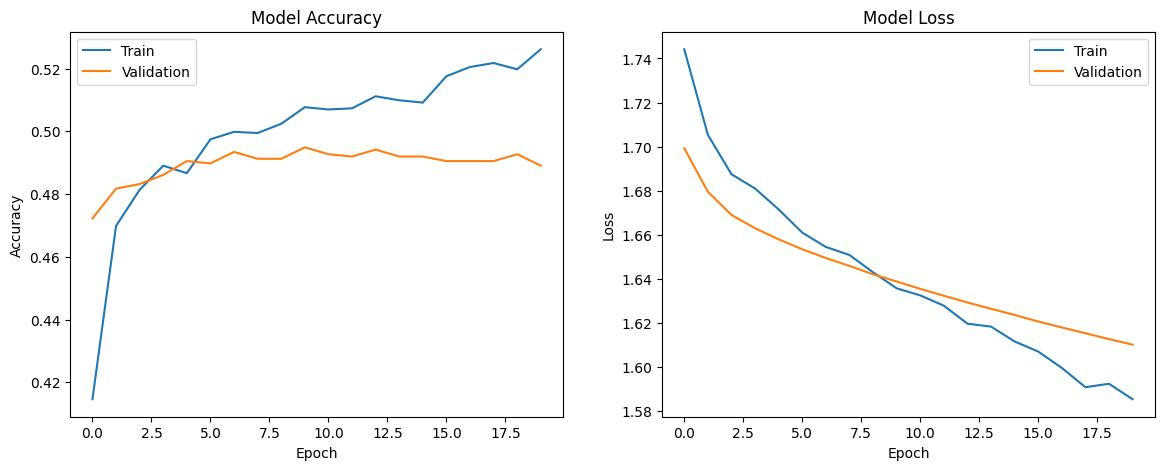

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper right')

plt.show()

Nous avons ici une accuracy très intéressante mais qui dont la validation acurracy stagne malgré l'utilisation d'un modèle considérablement plus complexe. Nous pouvons constater qu'à chaque itération, on réduit la perte (loss) à la fois pour l'entraînement et la validation. <br> Procédons désormais à l'optimisation de ce modèle. Nous n'avons pas trouvé comment réaliser de Grid Search CV (nous avons essayé avec `scikeras` mais cela ne fonctionnait pas). Nous avons néanmoins trouvé le package `keras_tuner` qui fait essentiellement la même chose, c'est-à-dire il aide à optimiser les hyperparamètres de notre modèle.

In [43]:
feature_columns = X_train.shape[1]
### construction de la fonction pour optimiser les hyperparamètres
def build_model(hp):
    layer1_units = hp.Int('layer1_units', min_value=32, max_value=1024, step=32)
    layer2_units = hp.Int('layer2_units', min_value=32, max_value=1024, step=32)
    l2_strength = hp.Float('l2_strength', min_value=0.001, max_value=0.1, sampling='log')
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.4, default=0.25, step=0.05)
    
    model = Sequential()
    model.add(Dense(layer1_units, activation='relu', kernel_regularizer=regularizers.l2(l2_strength), input_dim=feature_columns))
    model.add(Dense(layer2_units, activation='relu', kernel_regularizer=regularizers.l2(l2_strength)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=0.00001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    max_trials=20,
    objective="val_accuracy",
    executions_per_trial=1,
    overwrite=True,
    directory="data/test_res",
    project_name="ML_QRT",
)

tuner.search(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Trial 20 Complete [00h 00m 23s]
val_accuracy: 0.4926900565624237

Best val_accuracy So Far: 0.511695921421051
Total elapsed time: 00h 07m 08s


Nous avons ici une accuracy de validation très élevée par rapport aux autres modèles.

In [55]:
nmodels = 19
best_hyperparameters = tuner.get_best_hyperparameters(nmodels)
evaluation_results = tuner.oracle.get_best_trials(nmodels)
## pour chacun des modèles, on print les hyperparams et son score de validation
for i, (hyperparameters, trial) in enumerate(zip(best_hyperparameters, evaluation_results)):
    accuracy = trial.score
    print(f"Model {i+1}:")
    print(f"Hyperparameters: {hyperparameters.values}")
    print(f"Score: {round(accuracy, 4)}\n")


Model 1:
Hyperparameters: {'layer1_units': 800, 'layer2_units': 192, 'l2_strength': 0.010503211938757365, 'dropout_rate': 0.15000000000000002}
Score: 0.5117

Model 2:
Hyperparameters: {'layer1_units': 480, 'layer2_units': 800, 'l2_strength': 0.0024395026973415695, 'dropout_rate': 0.05}
Score: 0.5058

Model 3:
Hyperparameters: {'layer1_units': 544, 'layer2_units': 544, 'l2_strength': 0.02964232517209841, 'dropout_rate': 0.35000000000000003}
Score: 0.5029

Model 4:
Hyperparameters: {'layer1_units': 640, 'layer2_units': 896, 'l2_strength': 0.04998741129453312, 'dropout_rate': 0.0}
Score: 0.5015

Model 5:
Hyperparameters: {'layer1_units': 576, 'layer2_units': 416, 'l2_strength': 0.015324287478969592, 'dropout_rate': 0.1}
Score: 0.4993

Model 6:
Hyperparameters: {'layer1_units': 896, 'layer2_units': 768, 'l2_strength': 0.07871944529656774, 'dropout_rate': 0.25}
Score: 0.4971

Model 7:
Hyperparameters: {'layer1_units': 768, 'layer2_units': 896, 'l2_strength': 0.021438691695943517, 'dropout_r

In [51]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}") 


Best hyperparameters: {'layer1_units': 800, 'layer2_units': 192, 'l2_strength': 0.010503211938757365, 'dropout_rate': 0.15000000000000002}


In [57]:
final_model = build_model(best_hps) ## les meilleurs hyperparamètres correspondent au modèle 1
final_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))
final_eval = final_model.evaluate(X_test, y_test)

print(f"Test loss: {final_eval[0]}")
print(f"Test accuracy: {final_eval[1]}")

Epoch 1/50


C:\Users\meghn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3811 - loss: 6.5727 - val_accuracy: 0.4613 - val_loss: 6.4195
Epoch 2/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4654 - loss: 6.3967 - val_accuracy: 0.4766 - val_loss: 6.2897
Epoch 3/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4675 - loss: 6.2785 - val_accuracy: 0.4861 - val_loss: 6.1705
Epoch 4/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4834 - loss: 6.1575 - val_accuracy: 0.4912 - val_loss: 6.0548
Epoch 5/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4970 - loss: 6.0233 - val_accuracy: 0.4912 - val_loss: 5.9424
Epoch 6/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4911 - loss: 5.9157 - val_accuracy: 0.4876 - val_loss: 5.8318
Epoch 7/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5005 - loss: 5.7977 - val_accuracy: 0.4876 - val_loss: 5.7240
Epoch 8/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5152 - loss: 5.6807 - val_accuracy: 0.4825 - val_

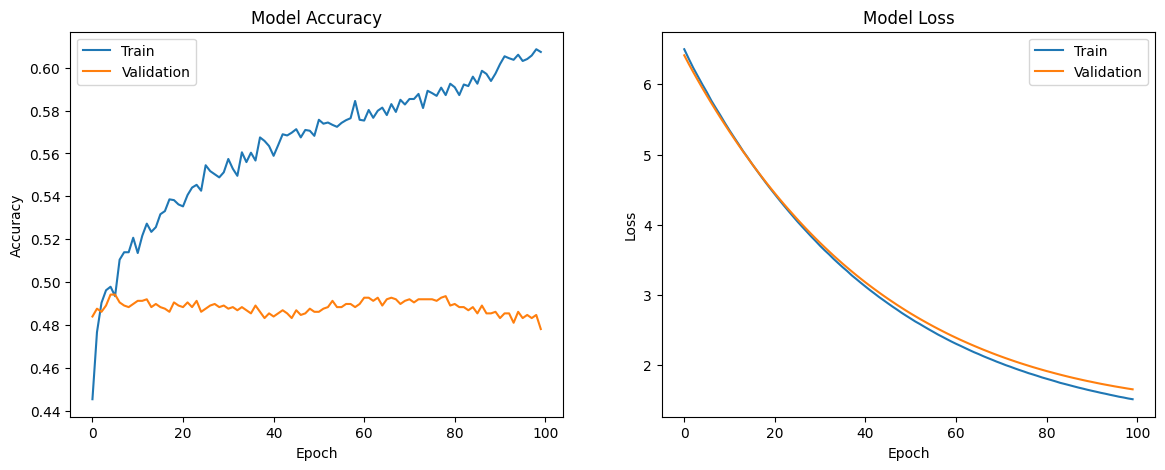

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper right')

plt.show()


La fonction de perte des ensembles d'entraînement et de validation diminuent régulièrement au fil des époques, ce qui est un bon signe. Cela indique que le modèle apprend et améliore ses performances sur les données d'apprentissage et de validation. De plus, celui nous montre qu'il n'y a pas de overfitting. En effet, généralement, un surajustement est indiqué lorsque la perte d'apprentissage continue à diminuer alors que la perte de validation commence à augmenter ou à stagner. Dans ce graphique, les pertes d'apprentissage et de validation diminuent toutes deux à des rythmes similaires, ce qui suggère qu'il n'y a pas de surajustement.

Enfin, le graphique montre une diminution régulière sans fluctuations majeures, ce qui indique que le modèle converge bien.

Pour terminer, vous trouverez ci-dessous une représentation de notre réseau de neurones pour le meilleur modèle.

![title](best_model.keras.png)
